# Demo
Here we provide a demo for calculating **Chebyshev confidence map**. If you have **prediction probability map** and **uncertainty map**, you can calculate Chebyshev confidence map. It is simple!   
If you also have **latent feature map**, you can implement our complete denoising method.


## 1. Load the data


In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
probability = torch.tensor(np.load('./demo/probability.npy'))
uncertainty = torch.tensor(np.load('./demo/uncertainty.npy'))
latent_features = torch.tensor(np.load('./demo/latent_features.npy'))

threshold = 0.5
pseudo_label = probability>threshold

print('The shape of vars:\nprobability:',probability.shape)
print('uncertainty:',uncertainty.shape)
print('latent_features:',latent_features.shape)
print('\nHere, the batch size equals to:',probability.shape[0])
print('The threshold for probability map is by default:',threshold)

The shape of vars:
probability: torch.Size([1, 1, 512, 512])
uncertainty: torch.Size([1, 1, 512, 512])
latent_features: torch.Size([1, 305, 128, 128])

Here, the batch size equals to: 1
The threshold for probability map is by default: 0.5


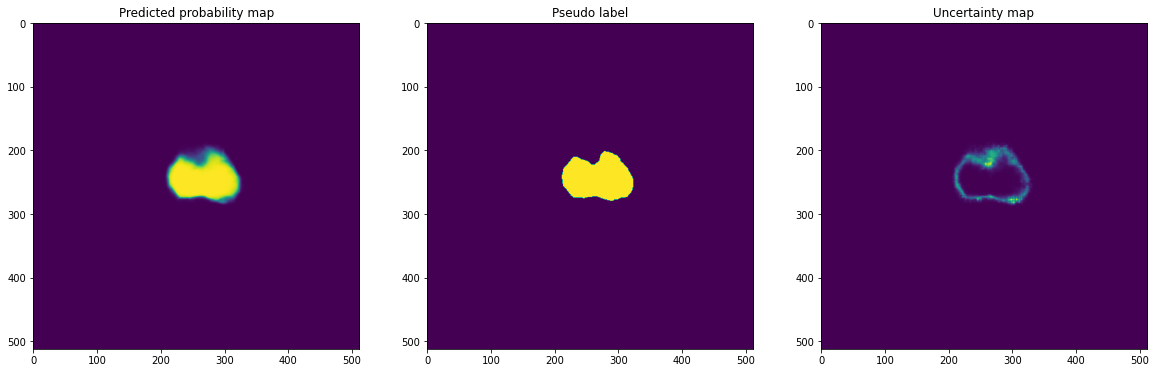

In [3]:
%matplotlib inline
plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.imshow(probability[0,0,:].cpu())
plt.title('Predicted probability map')
plt.subplot(1,3,2)
plt.imshow(pseudo_label[0,0,:].cpu())
plt.title('Pseudo label')
plt.subplot(1,3,3)
plt.imshow(uncertainty[0,0,:].cpu())
plt.title('Uncertainty map')

plt.show()

## 2. Compute the Chebyshev confidence map
Calculating a Chebyshev confidence map is very convenient and fast, given uncertainty and prediction.

In [4]:
def compute_mask_cheb(uncertain_map,prob_temp,thres = 0.5,P_thres = 0.025):
    # use chebyshev method to find the mask
    cheb_map = torch.square(uncertain_map)/(torch.square(uncertain_map)+torch.square(prob_temp-thres))
    mask_ = cheb_map<P_thres
    mask_ = mask_.int()
    return mask_, cheb_map

In [5]:
mask,cheb_map = compute_mask_cheb(uncertainty,probability,thres =threshold,P_thres =  0.05)
print('The shape is the same as the probability map:\nmask:',mask.shape)
print('cheb_map:',cheb_map.shape)

The shape is the same as the probability map:
mask: torch.Size([1, 1, 512, 512])
cheb_map: torch.Size([1, 1, 512, 512])


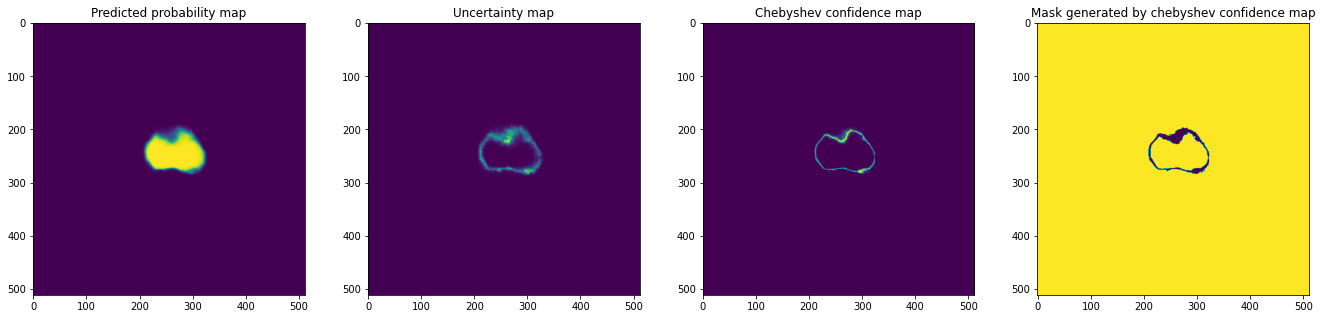

In [6]:
%matplotlib inline
plt.figure(figsize = (23,5))
plt.subplot(1,4,1)
plt.imshow(probability[0,0,:].cpu())
plt.title('Predicted probability map')
plt.subplot(1,4,2)
plt.imshow(uncertainty[0,0,:].cpu())
plt.title('Uncertainty map')
plt.subplot(1,4,3)
plt.imshow(cheb_map[0,0,:,:].cpu())
plt.title('Chebyshev confidence map')
plt.subplot(1,4,4)
plt.imshow(mask[0,0,:,:].cpu())
plt.title('Mask generated by chebyshev confidence map')
plt.show()

### Change P_thres
Set the 'P_thres' smaller can mask more region and probably mask more error.  
See the results of 'P_thres = 0.01'.

In [7]:
mask_2,_ = compute_mask_cheb(uncertainty,probability,thres =threshold,P_thres = 0.01)

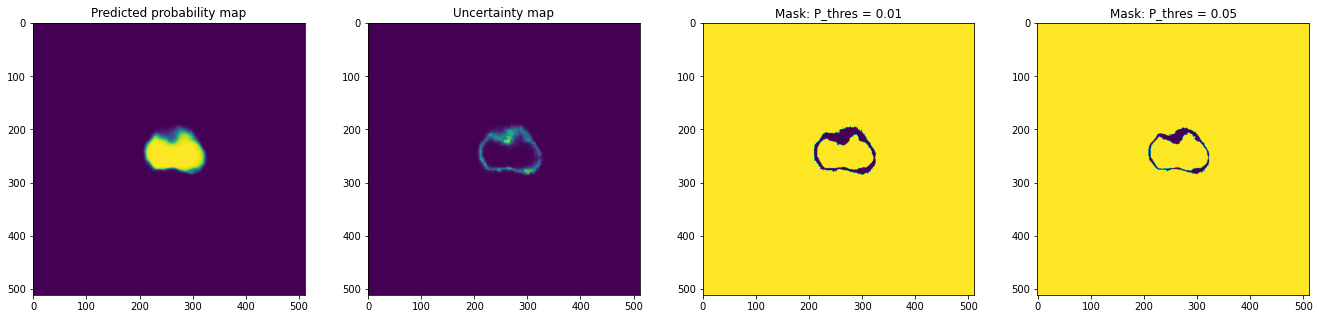

In [8]:
%matplotlib inline
plt.figure(figsize = (23,5))
plt.subplot(1,4,1)
plt.imshow(probability[0,0,:].cpu())
plt.title('Predicted probability map')
plt.subplot(1,4,2)
plt.imshow(uncertainty[0,0,:].cpu())
plt.title('Uncertainty map')
plt.subplot(1,4,3)
plt.imshow(mask_2[0,0,:,:].cpu())
plt.title('Mask: P_thres = 0.01')
plt.subplot(1,4,4)
plt.imshow(mask[0,0,:,:].cpu())
plt.title('Mask: P_thres = 0.05')
plt.show()

## 3. Add prototype denoising
Integrating prototype denoising can sometimes further improve model performance.
The relevant code is shown below.

In [9]:
def get_proto_pseudo_cheb(pseudo_label, feature, mask, prediction):
    target_0_obj = F.interpolate(pseudo_label[:,0:1,...], size=feature.size()[2:], mode='nearest')
    target_1_obj = F.interpolate(pseudo_label[:, 1:, ...], size=feature.size()[2:], mode='nearest')
    prediction_small = F.interpolate(prediction, size=feature.size()[2:], mode='bilinear', align_corners=True)
    mask_small = F.interpolate(mask.float(), size=feature.size()[2:], mode='bilinear', align_corners=True)
    target_0_bck = 1.0 - target_0_obj;target_1_bck = 1.0 - target_1_obj

    mask_0_obj = mask_small[:,0:1,:]
    mask_0_bck = mask_small[:,0:1,:]
    mask_1_obj = mask_small[:,1:,:]
    mask_1_bck = mask_small[:,1:,:]

    feature_0_obj = feature * target_0_obj*mask_0_obj;feature_1_obj = feature * target_1_obj*mask_1_obj
    feature_0_bck = feature * target_0_bck*mask_0_bck;feature_1_bck = feature * target_1_bck*mask_1_bck

    centroid_0_obj = torch.sum(feature_0_obj*prediction_small[:,0:1,...], dim=[2,3], keepdim=True)
    centroid_1_obj = torch.sum(feature_1_obj*prediction_small[:,1:,...], dim=[2,3], keepdim=True)
    centroid_0_bck = torch.sum(feature_0_bck*prediction_small[:,0:1,...], dim=[2,3], keepdim=True)
    centroid_1_bck = torch.sum(feature_1_bck*prediction_small[:,1:,...], dim=[2,3], keepdim=True)
    target_0_obj_cnt = torch.sum(mask_0_obj*target_0_obj*prediction_small[:,0:1,...], dim=[2,3], keepdim=True)
    target_1_obj_cnt = torch.sum(mask_1_obj*target_1_obj*prediction_small[:,1:,...], dim=[2,3], keepdim=True)
    target_0_bck_cnt = torch.sum(mask_0_bck*target_0_bck*prediction_small[:,0:1,...], dim=[2,3], keepdim=True)
    target_1_bck_cnt = torch.sum(mask_1_bck*target_1_bck*prediction_small[:,1:,...], dim=[2,3], keepdim=True)

    centroid_0_obj /= target_0_obj_cnt; centroid_1_obj /= target_1_obj_cnt
    centroid_0_bck /= target_0_bck_cnt; centroid_1_bck /= target_1_bck_cnt

    distance_0_obj = torch.sum(torch.pow(feature - centroid_0_obj, 2), dim=1, keepdim=True)
    distance_0_bck = torch.sum(torch.pow(feature - centroid_0_bck, 2), dim=1, keepdim=True)
    distance_1_obj = torch.sum(torch.pow(feature - centroid_1_obj, 2), dim=1, keepdim=True)
    distance_1_bck = torch.sum(torch.pow(feature - centroid_1_bck, 2), dim=1, keepdim=True)

    proto_pseudo_0 = torch.zeros([pseudo_label.shape[0], 1, feature.shape[2], feature.shape[3]]).to(pseudo_label.device)
    proto_pseudo_1 = torch.zeros([pseudo_label.shape[0], 1, feature.shape[2], feature.shape[3]]).to(pseudo_label.device)

    proto_pseudo_0[distance_0_obj < distance_0_bck] = 1.0
    proto_pseudo_1[distance_1_obj < distance_1_bck] = 1.0
    proto_pseudo = torch.cat((proto_pseudo_0, proto_pseudo_1), dim=1)
    proto_pseudo = F.interpolate(proto_pseudo, size=pseudo_label.size()[2:], mode='nearest')
    return proto_pseudo

In [10]:
proto_pseudo = get_proto_pseudo_cheb(torch.cat([pseudo_label.float(),pseudo_label.float()],dim=1), 
                                     latent_features, torch.cat([mask,mask],dim=1), torch.cat([1-cheb_map,1-cheb_map],dim=1))

In [11]:
mask_final = mask * (proto_pseudo[:,0:1,:]==pseudo_label)

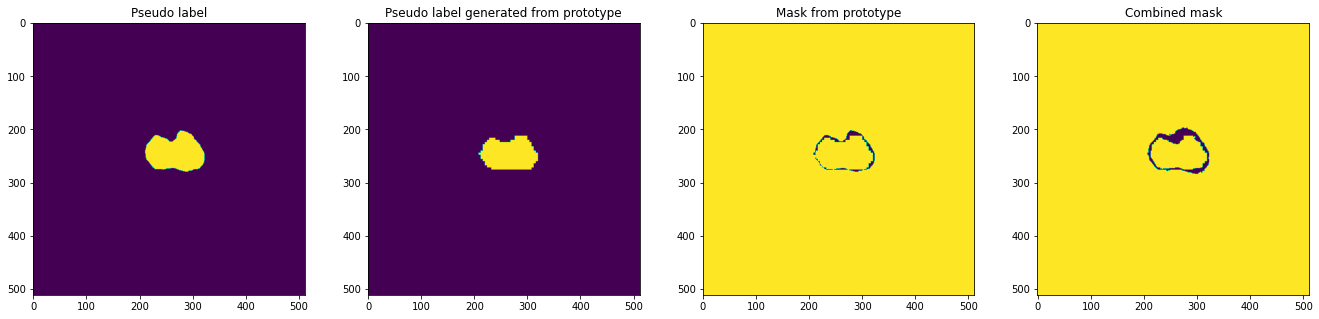

In [12]:
%matplotlib inline
plt.figure(figsize = (23,5))
plt.subplot(1,4,1)
plt.imshow(pseudo_label[0,0,:].cpu())
plt.title('Pseudo label')
plt.subplot(1,4,2)
plt.imshow(proto_pseudo[0,0,:,:].cpu())
plt.title('Pseudo label generated from prototype')
plt.subplot(1,4,3)
plt.imshow((proto_pseudo[:,0:1,:]==pseudo_label)[0,0,:,:].cpu())
plt.title('Mask from prototype')
plt.subplot(1,4,4)
plt.imshow(mask_final[0,0,:,:].cpu())
plt.title('Combined mask')


plt.show()